#  Симуляции случайных величин

В этой тетрадке мы: 

- оценим ошибки первого и второго рода для теста о доле с помощью симуляций (его мы применяли для Джеймса Бонда)
- посмотрим на то, как можно рассчитать число наблюдений необходимое для конкретных величин ошибок

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from tqdm import tqdm as tqdm_botebook

plt.style.use('ggplot')
%matplotlib inline

## 1. Генерация случайных величин в python


Иногда для решения задач по теории вероятностей или исследования свойств статистических алгоритмов нужно сгенерировать случайную выборку из какого-нибудь распределения. Чтобы сварить в `python` любую случайную величину, нужно сделать две вещи: 

* Создать генератор. 

Внутри пакета `scipy.stats` есть [много разных распределений.](https://docs.scipy.org/doc/scipy-0.14.0/reference/stats.html) Среди всего этого обилия нужно найти нужное распределение и задать его параметры. Давайте сделаем это  на примере **нормального распределения**, $X \sim N(\mu, \sigma^2)$. Того самого распределения, плотность которого выглядит как-то вот так: 

$$
f(x) = \frac{1}{\sigma \sqrt{2 \pi}} \cdot  e^{-\frac{(x - \mu)^2}{2 \sigma^2}}
$$


Параметр ```loc``` задаёт $\mu$, ```scale``` — среднеквадратичное отклонение $\sigma$.

In [3]:
norm_rv = stats.norm(loc=0, scale=1)  # задали генератор 

Когда конкретный генератор готов, у него можно вызывать разные методы: 

* `rvs` сгенерирует нам выборку из распределения объёма `size`
* `cdf` вычислит для нас значение функции распределения (cumulative distribution function) в указанной точке
* `pdf` вычислит значение плотности распредеелния (probability density function) в указанной точке 
* `ppf` вычислит квантиль, указанного уровня

[В документации](https://docs.scipy.org/doc/scipy-0.14.0/reference/stats.html) можно найти и другие методы, но мы с ними практически не будем встречаться в течение нашего курса (см. разел statistical functions).

In [16]:
sample = norm_rv.rvs(size=100)  # сгенерируем 100 значений
sample[:10]

array([ 1.19454553, -1.44413668, -0.22305495, -1.57405923,  2.17029184,
       -0.19223207,  1.19492169,  0.52780216, -2.10827209,  0.21234469])

Теперь мы можем немного поиграться с нашей случайной величиной. Например, __мы можем узнать $f(1)$__.

In [6]:
norm_rv.pdf(1)

0.24197072451914337

Можем построить картинку для плотности распределения. 

In [19]:
x = np.linspace(-3, 3, 100)

In [21]:
x[:10]

array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545])

In [75]:
norm_rv.rvs()

-0.12060154696734206

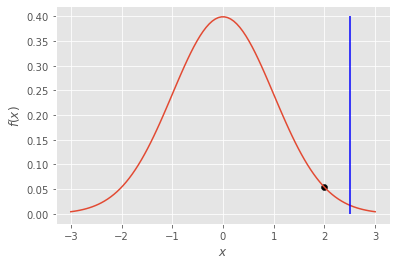

In [95]:
x = np.linspace(-3, 3, 100)
pdf = norm_rv.pdf(x)

plt.plot(x, pdf)
plt.ylabel('$f(x)$')
plt.xlabel('$x$')

# На ней же нарисуем f(1)
plt.scatter([2], [norm_rv.pdf(2)], color="black");
# plt.vlines(1, 0, 0.4, color='blue')
plt.vlines(2.5, 0, 0.4, color='blue')
x_fill = np.linspace(1, 3, 100)
y_fill = norm_rv.pdf(x_fill)
# plt.fill_between(x_fill, y_fill, color='blue')

Теперь узнаем значение функции распределения в точке $3$: $$F(1) = P(X \le 1) = \int_{-\infty}^1 f(x)dx$$

In [56]:
norm_rv.rvs()

-0.5419607995205569

In [ ]:
-0.5419607995205569 < 1 с вероятностью 84%

In [57]:
norm_rv.cdf(2)

0.9772498680518208

Можем построить картинку для функции распределения.

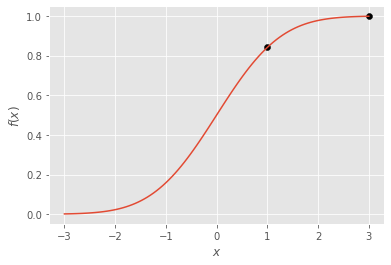

In [80]:
x = np.linspace(-3, 3, 100)
cdf = norm_rv.cdf(x)

plt.plot(x, cdf)
plt.ylabel('$f(x)$')
plt.xlabel('$x$')

# На ней же нарисуем F(1)
plt.scatter([1, 3], [norm_rv.cdf(1), norm_rv.cdf(3)], color="black");
plt.vlines(1, 0, 0.4, color='blue')

А теперь найдём ещё одну вероятность:

$$ P(1 < X < 3) = \int_1^3 f(x) dx = F(3) - F(1)$$

In [85]:
norm_rv.cdf(3)

0.9986501019683699

In [86]:
norm_rv.cdf(1)

0.8413447460685429

In [10]:
norm_rv.cdf(3) - norm_rv.cdf(1)

0.15730535589982697

Для полноты картины осталось только найти какой-нибудь квантиль! Не будем забывать о том, что квантиль уровня $\gamma$ это такое число $q$, что 

$$P(X < q) = \gamma$$

Найдём $95\%$ и нарисуем его на картинке с плотностью:

In [11]:
norm_rv.ppf(0.95)

1.6448536269514722

In [12]:
# картинка 

Обратите внимание, что всё, что мы сейчас делали - мы делали с теоретическим распределением. По аналогии можно работать с любым другим распределением. Например, с $t$-распределением, что бы это ни значило: 

In [14]:
t_rv = stats.t(df=1)  # задали генератор (у t-распределения свои параметры)
t_rv.rvs(5)

array([  0.67890765,   0.41517843,  -1.17214428, -32.91678322,
        -0.63896745])

## 2. Эмпирическое распределение 

Давайте теперь поработаем с выборкой. Обычно мы не знаем из какого распределения она пришла к нам в руки. Мы можем лишь смутно догадываться, что из нормального.

Мы можем посчитать какие-нибудь характеристики для нашей случайной величины! 

In [15]:
np.mean(sample)  # выборочное среднее(при больших n похоже на математическое ожидание)

-0.19594637463795372

In [16]:
np.var(sample)   # выборочная дисперсия

0.9094479710366647

In [17]:
np.std(sample)   # выборочное стандартное отклонение

0.9536498157272746

In [18]:
np.median(sample) # выборочная медиана

-0.17872527515486247

Построим гистограмму. Гистограмма - это эмпирическая оценка для плотности распределения. 

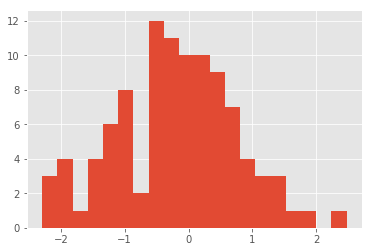

In [19]:
plt.hist(sample, bins=20);  # bins отвечает за число столбцов

Нарисуем гистограмму и плотность на одной картинке. 

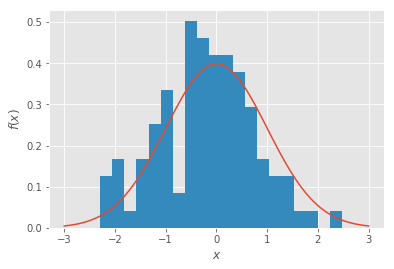

In [20]:
x = np.linspace(-3, 3, 100)
pdf = norm_rv.pdf(x)

# плотность 
plt.plot(x, pdf)

# гистограмма, параметр density отнормировал её. 
plt.hist(sample, bins=20, density=True);

plt.ylabel('$f(x)$')
plt.xlabel('$x$');

Построим по выборке эмпирическую функцию распределения. 

In [21]:
# для построения ECDF используем библиотеку statsmodels
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(sample)   # строим эмерическую функцию по выборке

plt.step(ecdf.x, ecdf.y)
plt.ylabel('$F(x)$')
plt.xlabel('$x$');

ImportError: cannot import name 'factorial' from 'scipy.misc' (/usr/local/lib/python3.7/site-packages/scipy/misc/__init__.py)

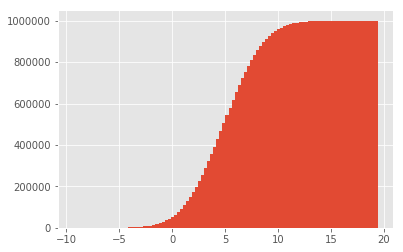

In [132]:
plt.hist(sample, bins=100, cumulative=True, histtype='bar');

Можно нарисовать её на одной картинке с теоретической:

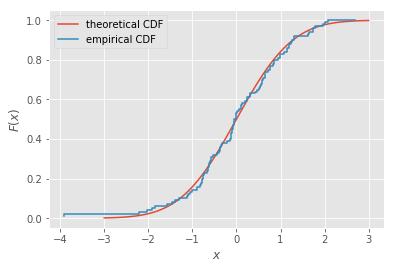

In [84]:
x = np.linspace(-3, 3, 100)

# теоретическа cdf 
cdf = norm_rv.cdf(x)
plt.plot(x, cdf, label='theoretical CDF')

# эмпирическая сdf
ecdf = ECDF(sample)
plt.step(ecdf.x, ecdf.y, label='empirical CDF')

plt.ylabel('$F(x)$')
plt.xlabel('$x$')
plt.legend(loc='upper left');

На следущей неделе мы более подробно поговорим про описательные статистики, гистограммы, функции распределения, и даже построим их на доске руками. 

## 3. Зачем всё это надо? 


__Чтобы решать рельные проблемы!__ Например, можно оценить математическое ожидание случайной величины $\frac{1}{X}$, где $X \sim N(5; 3)$ без взятия страшных интегралов. Для этого надо лишь вспомнить Закон Больших Чисел. Он говорит, что арифметическое среднее по большой выборке стремится по вероятности и почти наверное к математическому ожиданию. Поэтому мы просто сгенерируем большую выборку в миллион наблюдений и посчитаем выборочное среднее: 

In [94]:
n_obs = 10**6

norm_rv = sts.norm(loc=5, scale=3)  
x = norm_rv.rvs(n_obs)

np.mean(1/x)

0.24376390177523402

Если бы не было питонаб пришлось бы искать такой интеграл: 

$$
E \left(\frac{1}{X} \right) = \int_{-\infty}^{+\infty} \frac{1}{x} \cdot \frac{1}{\sigma \sqrt{2 \pi}} \cdot  e^{-\frac{(x - 5)^2}{2 \cdot 3^2}} dx.
$$

А не очень хочется. Конеччно же, генерация дала нам примерный ответ, но тем не менее. Кстати говоря, иногда интегралы не берутся, в этих ситуациях генерации нехило помогают. Особенно в байесовской статистике. Там постоянно вылезают интегралы, которые не берутся. 

__Другой пример.__ Также легко оценить многие вероятности. Например, оценим вероятность $P(X_1 + X_2 + X_3^2 > 5)$, где величины $X_i$ независимы и одинаково равномерно распределены $X_i \sim U[0;2]$:

In [98]:
n_obs = 10**6

# обратите внимание, что в этой функции задается левая граница и длина
# а не левая и правая границы
uniform_rv = sts.uniform(0, 2)

x_1 = uniform_rv.rvs(n_obs)
x_2 = uniform_rv.rvs(n_obs)
x_3 = uniform_rv.rvs(n_obs)

success = x_1 + x_2 + x_3**2 > 5
success[:5]

array([False, False, False, False, False])

In [100]:
np.sum(success) / n_obs

0.147505

Здесь вектор success будет содержать значение `True` там, где условие `x_1 + x_2 + x_3**2 > 5` выполнено, и `False` там, где условие не выполнено. При сложении командой `np.sum()` каждое `True` будет посчитано как единица, а каждое `False` как ноль. Поэтому `np.sum(success)` даст количество раз, когда условие `x_1 + x_2 + x_3**2 > 5` выполнено.

Как найти такую вероятность руками? Если вы хорошо учили теорию вероятностей, вы должны понимать, что надо будет пару раз воспользоваться формулой свёртки и найти несколько интегралов. 

__Ещё пример.__ давайте найдём условную вероятность $P(X_1 + X_2 > 0.8 \mid X_3 < 0.1)$. Снова используем для этого всю мощь `numpy` и сделаем срез по всем объектам, попавшим под условие.

In [101]:
n_obs = 10**6

uniform_rv = sts.uniform(0, 2)

x_1 = uniform_rv.rvs(n_obs)
x_2 = uniform_rv.rvs(n_obs)
x_3 = uniform_rv.rvs(n_obs)

uslovie = x_3 < 0.1

# x[uslovie] оставит в векторе только те элементы, где uslovie == True
success = x_1[uslovie] + x_2[uslovie] > 0.8
np.sum(success) / np.sum(uslovie)

0.9212774898445161

In [102]:
# можно посмотреть сколько раз за всю симуляцию x_3 < 0.1
np.sum(uslovie)

49973

## 4. Генерация выборок

С помощью таких же нехитрых манипуляций можно симулировать различные события. Например, можно сгенерировать выборку без повторений из вектора `1:10` размера `5`. Все элементы будут выбираться равновероятно.

Мы это будем делать [с помощью `np.random`.](https://docs.scipy.org/doc/numpy-1.15.0/reference/routines.random.html) Внутри numpy реализованы самые простые генераторы, и их, обычно, использовать довольно удобно. 

In [122]:
np.random.choice(np.arange(1,11), size=5, replace=False) # выборка без повторений

array([ 6, 10,  9,  2,  7])

Можно делать генерации с повторениями, параметр `replace` базово равен `True`.

In [123]:
np.random.choice(np.arange(1,11), size=5) # с повторениями

array([5, 6, 1, 2, 2])

А ещё можно самостоятельно расставить вероятности событий. Давайте, например ссимулируем 10 подбрасываний неправильной монетки!

In [124]:
np.random.choice(['Орёл', 'Решка'], size=10, p=[0.3, 0.7]) # с повторениями

array(['Решка', 'Решка', 'Орёл', 'Решка', 'Орёл', 'Решка', 'Орёл',
       'Решка', 'Решка', 'Решка'], dtype='<U5')

А если упороться и ссимулировать огромное число наблюдений, то можно даже оценить вероятность выпадения решек. Хвала __Закону Больших Чисел__ за это!

In [127]:
x = np.random.choice(['Орёл', 'Решка'], size=10**6, p=[0.3, 0.7])
np.mean(x == 'Решка')

0.69941

Функция `np.mean` посчитает долю `True` и выдаст нам долю решек.

## 5. Зёрна 

Если выполнить команду `rnorm(10, mean = 2, sd = 3)` на двух разных компьютерах или два раза на одном и том же, то результат будет разный. Не зря же они случайные :) Однако генерирование случайных величин никак не противоречит идее абсолютно точной воспроизводимости исследований. Для того, чтобы получились одинаковые результаты, необходимо синхронизировать генераторы случайных чисел на этих двух компьютерах. Делается это путём задания зерна генератора случайных чисел (seed). Зерно также называют стартовым значением. В качестве зерна подойдёт любое целое число.

In [ ]:
qrnorm(1, mean = 2, sd = 3)

In [ ]:
rnorm(1, mean = 2, sd = 3)

__Угадайте, какие числа чаще всего используют для зёрен?__

Многие алгоритмы в анализе данных в какой-то степени основаны на случайности (например в самом начале обучения веса берутся из какого-то распределения или обучение идёт на случайной подвыборке). Чтобы добиться воспроизводимых, одинаковых результатов, не зависящих от запуска, нужно устанавливать зерно генерации. 